In [1]:
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
from GB84 import variables, rho_m, v,cloud_heights, h_out, phi, f, non_dim_numbers
from kalman_filter import kalman_filter as kf

c:\Users\chari\miniconda3\envs\mude\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Testing the model

In [2]:
measurements = xr.open_mfdataset(r'data\davis-TUD-GV_Green_Village_202407.nc')

c:\Users\chari\miniconda3\envs\mude\Lib\site-packages\xarray\backends\plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [3]:
var = ['temperature','pressure','humidity','rain_rate']
measurements = measurements[var]
measurements = measurements.dropna(dim='time',how='any')

In [4]:
#Kalman filter measurements

kf_measurements = measurements['rain_rate'].values[7000:10000:30]

In [5]:
#inputs

#temperature on the ground
T_surf_C = measurements['temperature'].values[7000:10000] #[C]
T_surf = T_surf_C + 273.15    # [K]

#pressure
p_surf = measurements['pressure'].values[7000:10000]*100    #[Pa]

#dew point temperature
RH = measurements['humidity'].values[7000:10000]
alpha_T = 17.27*T_surf_C/(T_surf_C + 237.7) + np.log(RH/100) #from http://dx.doi.org/10.31648/ts.5425
T_d_arr = 237.7*alpha_T/(17.27 - alpha_T) + 273.15      #[K]

#state
X = np.zeros(len(T_surf))
X[0] = 20   #initial state in kg/m2
Sigma = np.zeros(len(T_surf))
Sigma[0] = 5 #initial state covariance in kg/m2

#timestep
dt= 60      #timestep in s

In [6]:
#loop for finding the precipitation given the T_0 and p
P = np.zeros(len(T_surf))
P_0 = np.zeros(len(T_surf))
for i in range(0,len(T_surf)):
    #inputs
    T_0 = T_surf[i]
    p_0 = p_surf[i]
    T_d = T_d_arr[i]

    #meteorological variables
    p_s,T_s,p_t, T_m, T_t,T_s_up, p_s_up = variables(T_0, T_d, p_0, obs=False).run()
    rho = rho_m(T_s,T_t,p_s,p_t)
    v_updr = v(T_m,T_s_up)
    Z_c,Z_b = cloud_heights(T_s,T_t,T_0,p_s,p_t,p_0)
    O_b,O_t,h_v = h_out(v_updr,Z_c).run()   #outflows and sources of water
    
    #precipitation in kg/m2/s
    P_0[i] = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()*X[0]
    P[i] = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()*X[i] #*X[i] if we are using the updated state
    
    #state without Kalman filter
    #X[i+1] = X[i] + dt*(f(T_d,p_0,p_t,T_t,rho,v_updr) - h_out(v_updr,Z_c).run()[2]*X[i])
    print(T_s_up,T_m)
    #state with Kalman filter   
    if i>0:
        if (i%30)==0:
            # we assume that we receive a precipitation update every 30mins
            j = int(i/30)
            if kf_measurements[j]>0:
                phi_kf = phi(T_0, p_0, T_d, Z_b, Z_c,v_updr).calculate_phi()
                h_kf = h_out(v_updr,Z_c).run()[2]
                f_kf = f(T_d,p_0,p_t,T_t,rho,v_updr)
            
                kalman_f = kf(X[i], Sigma[i], dt,h_kf,phi_kf,f_kf,kf_measurements[j]) 
                X[i],Sigma[i] = kalman_f.update()
    
    if i<(len(T_surf)-1):
        X[i+1] = X[i]
        Sigma[i+1] = Sigma[i]

277.0008339480045 281.82521258847197
277.0008339480045 281.82521258847197
277.0008339480045 281.82521258847197
277.00120705610976 281.8255034355345
277.00157932930944 281.8257936236169
277.00157932930944 281.8257936236169
277.00157932930944 281.8257936236169
277.00120705610976 281.8255034355345
277.00157932930944 281.8257936236169
277.00157932930944 281.8257936236169
277.04868973286534 281.8767180973707
277.04794502821653 281.87613790426826
277.0483173681563 281.8764279952405
277.0483173681563 281.8764279952405
277.04794502821653 281.87613790426826
277.04794502821653 281.87613790426826
277.04794502821653 281.87613790426826
277.04906298239695 281.87700888067934
277.10477673568107 281.93747335988627
277.10477673568107 281.93747335988627
277.10477673568107 281.93747335988627
277.10477673568107 281.93747335988627
277.10477673568107 281.93747335988627
277.10477673568107 281.93747335988627
277.15151521240585 281.98809539920535
277.15151521240585 281.98809539920535
277.15226117075264 281.9886

### Plots and results

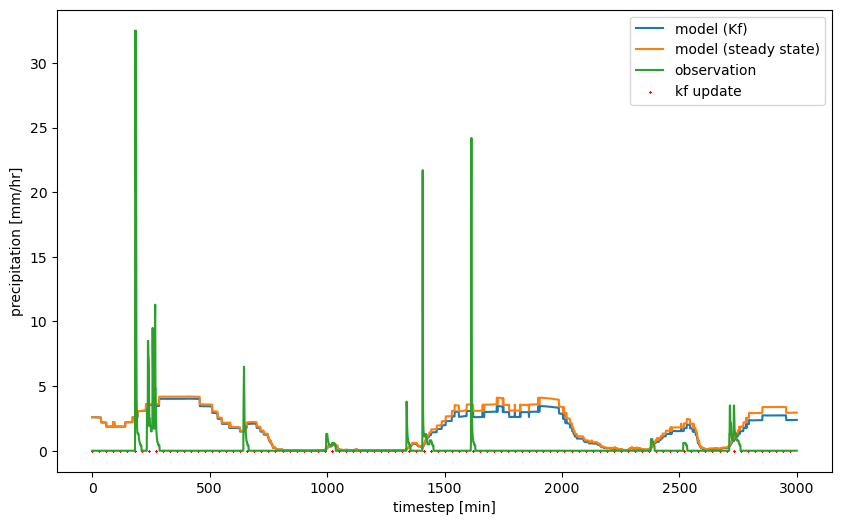

In [7]:
plt.figure(figsize=(10,6))
t_step = np.linspace(0,len(P),len(P))

plt.plot(t_step,P*3600,label='model (Kf)')   #P [kg/m2/s] = P/1000kg/m3 = P/1000 m/s = P* 3600 [mm/hr]
plt.plot(t_step,P_0*3600,label='model (steady state)')
plt.plot(t_step,measurements['rain_rate'].values[7000:10000],label='observation')
plt.scatter(t_step[0::30],np.zeros((len(kf_measurements))),label='kf update',marker='x',s=0.6,color='red')
plt.xlabel('timestep [min]')
plt.ylabel('precipitation [mm/hr]')
plt.legend()
plt.show()


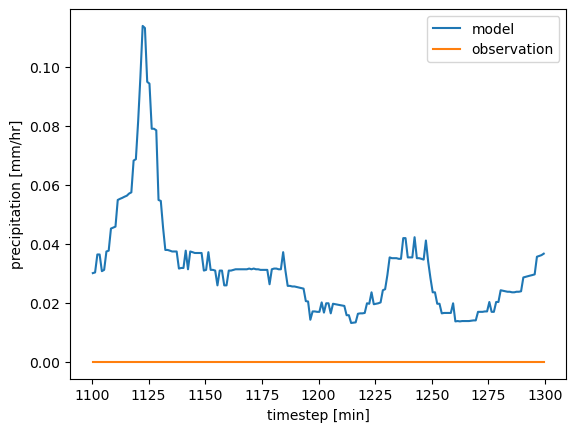

In [8]:
#zooming when no rain is observed

t_step = np.linspace(0,len(P),len(P))
plt.plot(t_step[1100:1300],P[1100:1300]*3600,label='model')
plt.plot(t_step[1100:1300],measurements['rain_rate'].values[8100:8300],label='observation')
plt.legend()
plt.xlabel('timestep [min]')
plt.ylabel('precipitation [mm/hr]')
plt.show()


Text(0, 0.5, 'liquid water [kg/m^2]')

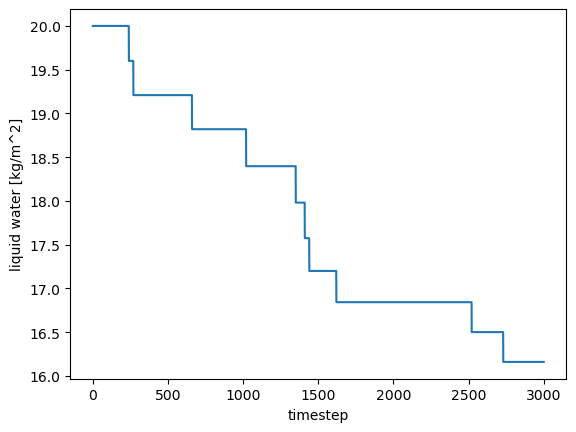

In [9]:
#state evolution

plt.plot(t_step,X)
plt.xlabel('timestep')
plt.ylabel('liquid water [kg/m^2]')

In [10]:
v_arr = np.zeros(len(T_surf))
O_b_arr = np.zeros(len(T_surf))
O_h_arr = np.zeros(len(T_surf))
I_arr = np.zeros(len(T_surf))

for i in range(0,len(T_surf)):
    #inputs
    T_0 = T_surf[i]
    p_0 = p_surf[i]
    T_d = T_d_arr[i]

    #meteorological variables
    p_s,T_s,p_t, T_m, T_t,T_s_up, p_s_up = variables(T_0, T_d, p_0, obs=False).run()
    rho = rho_m(T_s,T_t,p_s,p_t)
    v_updr = v(T_m,T_s_up)
    v_arr[i] = v_updr
    Z_c,Z_b = cloud_heights(T_s,T_t,T_0,p_s,p_t,p_0)
    O_b,O_t,h_v = h_out(v_updr,Z_c).run()   #outflows and sources of water
    O_b_arr[i] = O_b*X[i]*non_dim_numbers(v_updr)[0]/Z_c
    O_h_arr[i] = O_t*X[i]*non_dim_numbers(v_updr)[0]/Z_c
    I_arr[i] = f(T_d,p_0,p_t,T_t,rho,v_updr)
     


Text(0, 0.5, 'updraft velocity [m/s]')

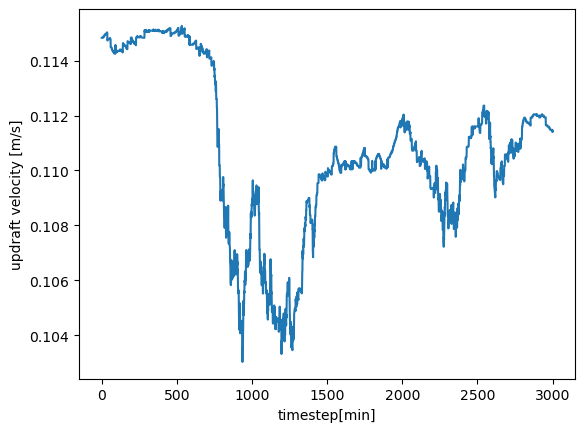

In [11]:
plt.plot(t_step,v_arr)
plt.xlabel('timestep[min]')
plt.ylabel('updraft velocity [m/s]')

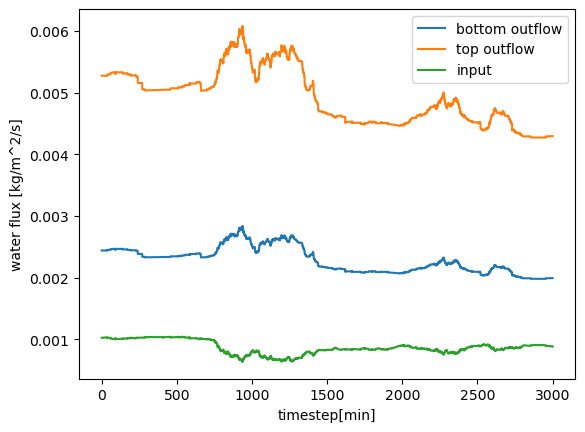

In [12]:
plt.plot(t_step,O_b_arr,label='bottom outflow')
plt.plot(t_step,O_h_arr,label='top outflow')
plt.plot(t_step,I_arr,label='input')
plt.xlabel('timestep[min]')
plt.ylabel('water flux [kg/m^2/s]')
plt.legend()

In [13]:
X[i]*non_dim_numbers(v_updr)[0]/Z_c

array([0.00214703])

In [14]:
T_t

array([247.33245945])